# **Adan [Adaptive and Nesterov Momentum]**
First order Optimizer.

It improves upon Adam and AdamW. It achieves faster convergence and better performance by making two main changes to the Adam formula:
1. **it incorporates Nesterov-style momentum**, which uses a "look-ahead" step to make smarter, more stable updates.
2. **It uses the gradient difference** (the change between the current and previous gradient) in its adaptive term, allowing it to slow down whe the loss landscape is becoming unstable or bumpy.

Like AdamW, it also uses **decoupled weight decay**.

---

## **The Algorithm**

Adan maintains three moving averages for each parameter, instead of Adam's two. The update at each timestep `t` follows these steps:

1. **Get Current Gradient:** 
    $$ g_{t} = \nabla L(w_{t}) $$

    computes the gradient of the loss function for the current parameters.

2. **Update First Moment (Momentum):** 
    $$ m_{t} = (1 - \beta_{1}) m_{t-1} + \beta_{1} g_{t} $$

    This is Exponentially weighted moving average (EWMA) of the gradients, which captures consisten direction of descent.

3. **Update Gradient Difference:** 
    $$ v_{t} = (1 - \beta_{2}) v_{t-1} + \beta_{2} (g_{t} - g_{t-1}) $$

    this is EWMA of the difference between the current and previous gradients. It tracks the "velocity" of the gradient itself.

4. **Update Second Moment:** 
    $$ n_{t} = (1 - \beta_{3}) n_{t-1} + \beta_{3}( g_{t} + (1 - \beta_{2}) (g_{t} - g_{t-1})^{2}) $$

    This is EWMA of the squared **Nesterov-style "look ahead" gradient**. it measures the variance of the extrapolated gradient.

5. **Parameter Update:**

    It combines the momentum and the gradient difference velocity, scaled by the adaptive term from step 4. Decoupled weight decay is then applied.
    
    * Compute the adaptive learning rate:
    $$\eta_{t} = \frac{\eta}{\sqrt{n_{t} + \epsilon}}$$
    * Apply the update with decoupled weight decay:
    $$w_{t+1} = \frac{1}{1+\eta\lambda} (w_{t} - \eta_{t} \cdot  (m_{t} + (1 - \beta_{2})v_{t}))$$

---

The core idea remains the same, but the corrected formulas are more precise:
* Adan uses **momentum** $(m_{t})$ to know which way to go.
* It looks at the **change in the gradient over time** $(v_{t})$ to understand the stability of the path.
* It combines these to make a **"look ahead" guess** and then **scales the step size** based on how stable the guess has been $(n_{t})$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

def linear_model(X, w, b): return X @ w.data + b.data
def mse_loss(y_true, y_pred): return np.mean((y_true - y_pred)**2)

def compute_gradients(X, y_true, y_pred, w, b):
    n_samples = len(y_true)
    grad_pred = -2 * (y_true - y_pred) / n_samples
    w.grad = X.T @ grad_pred
    b.grad = np.sum(grad_pred)

In [3]:
class AdamW:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        self.params = params; self.lr = lr; self.beta1 = beta1; self.beta2 = beta2; self.eps = eps
        self.weight_decay = weight_decay
        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad**2)
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            update_term = self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            p.data -= update_term
            p.data -= self.lr * self.weight_decay * p.data
    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.data)

In [4]:
class Adan:
    def __init__(self, params, lr=0.01, beta1=0.98, beta2=0.92, beta3=0.99, weight_decay=0.02, eps=1e-8):
        self.params = params; self.lr = lr
        self.beta1 = beta1; self.beta2 = beta2; self.beta3 = beta3
        self.weight_decay = weight_decay; self.eps = eps
        
        self.m = [np.zeros_like(p.data) for p in self.params] # First moment
        self.v = [np.zeros_like(p.data) for p in self.params] # Gradient difference velocity
        self.n = [np.zeros_like(p.data) for p in self.params] # Second moment
        self.g_prev = [np.zeros_like(p.data) for p in self.params] # Previous gradient

    def step(self):
        for i, p in enumerate(self.params):
            # Step 1
            grad_diff = p.grad - self.g_prev[i]
            
            # Step 2, 3, 4
            self.m[i] = (1 - self.beta1) * self.m[i] + self.beta1 * p.grad
            self.v[i] = (1 - self.beta2) * self.v[i] + self.beta2 * grad_diff
            nesterov_term = p.grad + (1 - self.beta2) * grad_diff
            self.n[i] = (1 - self.beta3) * self.n[i] + self.beta3 * (nesterov_term**2)
            
            # Step 5
            # Compute adaptive learning rate
            adaptive_lr = self.lr / (np.sqrt(self.n[i]) + self.eps)
            
            # Perform update with decoupled weight decay
            update_term = adaptive_lr * (self.m[i] + (1 - self.beta2) * self.v[i])
            p.data *= (1 - self.lr * self.weight_decay) # Decay step
            p.data -= update_term # Gradient step
            
            # Store current gradient for next iteration
            self.g_prev[i] = p.grad.copy()

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

Starting training for AdamW...
Optimizer: AdamW (lr=0.1)
Final Weights: w=2.18, b=1.03

Starting training for Adan...
Optimizer: Adan (lr=0.01)
Final Weights: w=2.02, b=1.09



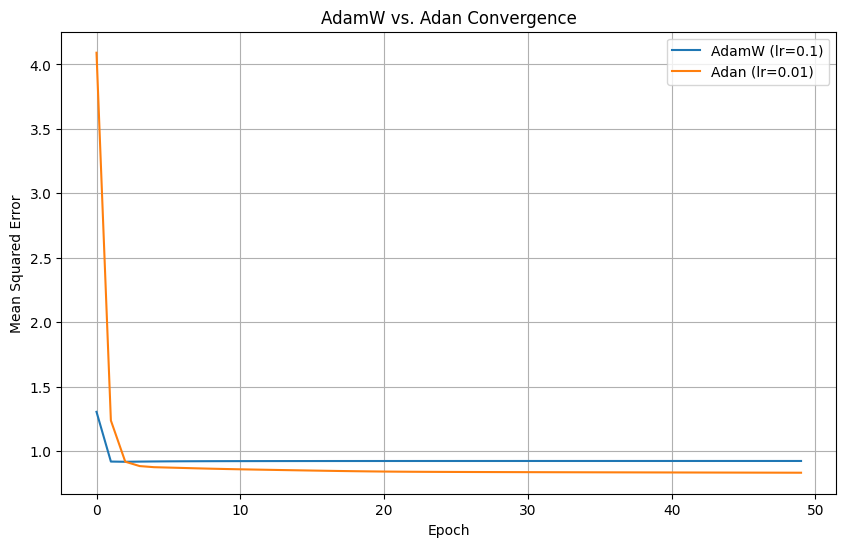

In [6]:
X = 2 * np.random.rand(100, 1)
y = 1 + 2 * X + np.random.randn(100, 1)

def train(optimizer, epochs=50):
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            x_sample, y_sample = X[i:i+1], y[i:i+1]
            w, b = optimizer.params
            y_pred = linear_model(x_sample, w, b)
            epoch_loss += mse_loss(y_sample, y_pred)
            optimizer.zero_grad()
            compute_gradients(x_sample, y_sample, y_pred, w, b)
            optimizer.step()
        loss_history.append(epoch_loss / len(X))
    current_lr = getattr(optimizer, 'lr', 'N/A')
    print(f"Optimizer: {optimizer.__class__.__name__} (lr={current_lr})")
    w, b = optimizer.params
    print(f"Final Weights: w={w.data.item():.2f}, b={b.data.item():.2f}\n")
    return loss_history

# Compare AdamW and Adan
print("Starting training for AdamW...")
np.random.seed(42)
w_adamw = Parameter(np.random.randn(1, 1)); b_adamw = Parameter(np.zeros(1))
adamw_optimizer = AdamW(params=[w_adamw, b_adamw], lr=0.1, weight_decay=0.01)
adamw_losses = train(adamw_optimizer)

print("Starting training for Adan...")
np.random.seed(42)
w_adan = Parameter(np.random.randn(1, 1)); b_adan = Parameter(np.zeros(1))
# Adan uses different beta defaults and often a smaller LR
adan_optimizer = Adan(params=[w_adan, b_adan], lr=0.01, weight_decay=0.01)
adan_losses = train(adan_optimizer)

# --- Plot the results ---
plt.figure(figsize=(10, 6))
plt.plot(adamw_losses, label='AdamW (lr=0.1)')
plt.plot(adan_losses, label='Adan (lr=0.01)')
plt.title('AdamW vs. Adan Convergence')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()